# Experiment 1 - Next Day Market Trend Labeled Embeddings
1. Imports and constants
2. Load price and textual data
3. Label price data and merge with textual data
4. Create datasets and dataloaders
5. Exploratory Data Analysis
6. Evaluate the base model
7. Train the model
8. Evaluate the model

## Imports and constants

In [1]:
import os
import sys

In [2]:
current_working_directory = os.getcwd()
new_path = os.path.join(os.path.dirname(current_working_directory), "src")
if new_path not in sys.path:
    sys.path.append(new_path)

In [21]:
import datetime
from datetime import timedelta
from typing import List, Callable

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas.tseries.offsets import DateOffset
from transformers import (
    AutoTokenizer,
    AutoModel,
)
from tqdm import tqdm
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    roc_auc_score,
)
from sklearn.model_selection import train_test_split
from scipy.special import softmax
import torch
from torch.utils.data import DataLoader
from datasets import Dataset, ClassLabel


# internal imports
from type import Experiment
from model import CryptoBERT
from labeler import TripleBarrierLabeler, TrueRangeLabeler
from dataset import HFDataset, TextDataset
from util import *
from functools import partial

## Load price and textual data

In [4]:
def pandas_data_loader(addr: str, columns: List[str], *transforms: Callable[[pd.DataFrame], pd.DataFrame]) -> pd.DataFrame:
    # Load the data from the CSV file
    df = pd.read_csv(addr, usecols=columns)

    # Apply each transform to the DataFrame
    for transform in transforms:
        df = transform(df)

    return df

In [5]:
# Transform index to datetime
def index_to_datetime(df, unit="s"):
    df.index = pd.to_datetime(df.index, unit=unit)
    return df
# Transform col to index
to_index = lambda col, df: df.set_index(col)

In [6]:
# Loading the price data
columns = ["timestamp", "close", "open", "high", "low", "volume"]
price_df = pandas_data_loader("../raw/daily-2020.csv", columns, partial(to_index, "timestamp"), index_to_datetime)

In [7]:
columns = ["text_split", "date"]
text_df = pandas_data_loader("../raw/combined_tweets_2020_labeled.csv", columns, partial(to_index, "date"), partial(index_to_datetime, unit='ns'))

## Label price data and merge with textual data

In [24]:
def plot_labels(price_series, bands, labels):
    """
    Plot price series with bullish and bearish areas.
    
    Parameters:
    - price_series: A pandas Series of prices.
    - bands: pandas series containing the bands
    - labels: the list of labels (-1, 0, 1).
    """
    # Create a new figure
    fig, ax1 = plt.subplots(figsize=(14, 6))
    ax2 = ax1.twinx()
    
    # Plot the price series
    ax1.plot(price_series.index, price_series.values, label='Price', color='blue')
    
    # Draw a box for each window
    for band in bands:
        # Shift "from" and "to" by half a day
        from_timestamp = band["from"] - DateOffset(hours=12)
        to_timestamp = band["to"] + DateOffset(hours=12)
        
        # Ensure the timestamps are within the price series index
        from_timestamp = max(from_timestamp, price_series.index[0])
        to_timestamp = min(to_timestamp, price_series.index[-1])
        
        # Add the band
        ax2.fill_betweenx(ax1.get_ylim(), from_timestamp, to_timestamp, color='green' if band["label"] == labels[2] else "red" if band["label"] == labels[0] else 'white' , alpha=0.3)

    # Add a legend
    ax1.legend()
    
    # Show the plot
    plt.show()

In [25]:
def band_generator(labels):
    bands = [{'label': labels.iloc[0], 'from': labels.index[0]}]
    for l, i in enumerate(labels):
        if i == bands[-1]["label"]:
            pass
        else:
            bands[-1]["to"] = labels.index[l]
            # Check if l + 1 is within the range of the labels' indices
            if l + 1 < len(labels):
                bands.append({'label': i, 'from': labels.index[l + 1]})
    
    # Check if the last band has a 'to' field
    if 'to' not in bands[-1]:
        bands[-1]['to'] = labels.index[-1]
    
    return bands

In [8]:
labeler = TripleBarrierLabeler(volatility_period=10, upper_barrier_factor=1.5, lower_barrier_factor=1.2, vertical_barrier=7, min_trend_days=2, barrier_type='volatility')

In [35]:
labeler.fit(price_df)
labeled_df = labeler.transform()

In [36]:
labeled_df.label.value_counts()

label
2    151
1    142
0     73
Name: count, dtype: int64

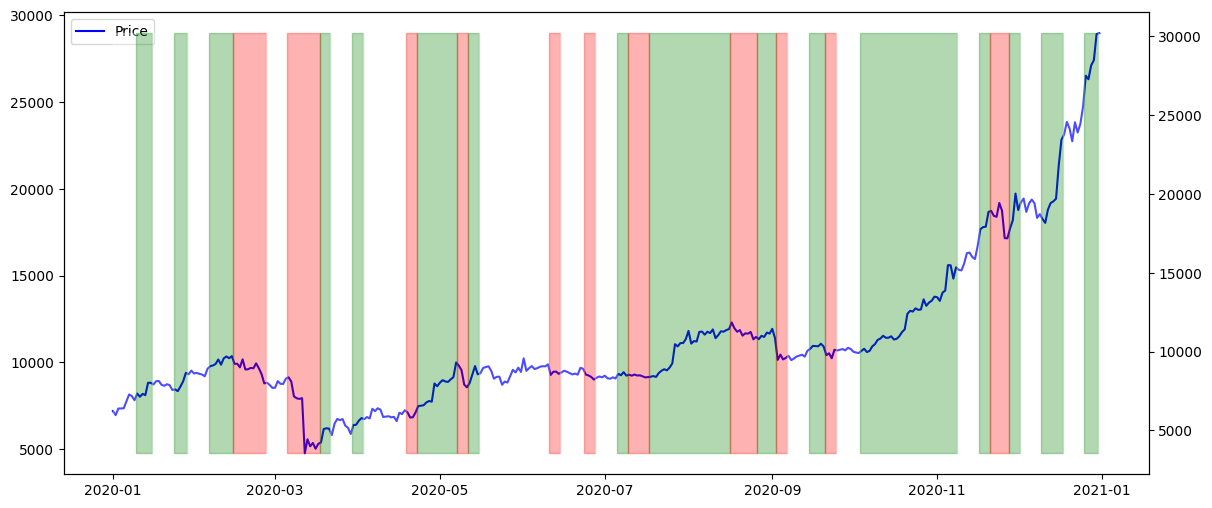

In [37]:
prices = labeled_df
bands = band_generator(prices.label)
plot_labels(prices.close, bands, [0,1,2])

In [38]:
# Shift the labels such that for each day, the label is set to the next day's label
labeled_df.label = labeled_df.label.shift(-1)
labeled_df = labeled_df[:-1]

In [41]:
labeled_df = text_df.merge(
    labeled_df[["label"]], left_index=True, right_index=True, how="left"
)

In [44]:
labeled_df.dropna(inplace=True)

In [47]:
labeled_df.label.value_counts()

label
2.0    27788
1.0    23991
0.0    12313
Name: count, dtype: int64

In [48]:
labeled_df.head()

,text_split,label
2020-01-01,is the year of bitcoin bitcoin is up in decade...,1.0
2020-01-01,activity and bases when can print they need go...,1.0
2020-01-01,address related to his announcement why they b...,1.0
2020-01-01,xrp btc btc price action is similar to bitcoin...,1.0
2020-01-01,about cryptocurrency and will be the beginning...,1.0


## Create datasets and dataloaders